# Étude de quelques modulations
<!-- vincent.mazet@unistra.fr, 03/2022 -->

Dans ce TP, on veut étudier les propriétés et les effets des modulations numériques.
Comme ce sont des signaux analogiques et aléatoires, on effectue les calculs en utilisant les outils du traitement statistique du signal.
Pour éviter des calculs fastidieux, on va utiliser les outils numériques sur des signaux simulés.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

## Utilisation du module comnumfip

Le module `comnumfip` regroupe de fonctions particulières pour faire les TP.
Il s'agit d'un unique fichier téléchargeable sur :
https://github.com/vincmazet/comnumfip.
Une fois le fichier téléchargé, il suffit de l'ajouter dans le dossier contenant le notebook.

L'aide des fonctions de ce module est accessible directement sur la page web du module, ou bien en utilisant l'instruction `help(fonction)`. Par exemple :

In [2]:
import comnumfip as cnf
help(cnf.randmary)

Help on function randmary in module comnumfip:

randmary(N, p)
    Génération d'une séquence M-aire.
    
    Entrées :
    N (scalar) : taille de la séquence (nombre de symboles)
    P (array)  : probabilité des symboles (sa taille correspond à la taille de l'alphabet)
    
    Sortie :
    c (array) : séquence aléatoire M-aire où M = len(P).
    
    Exemples :
    
    # séquence binaire de taille 1000, symboles équiprobables :
    c1 = randmary(1000,[0.5, 0.5])
    
    # séquence binaire de taille 100, p("0") = 0.3, p("1") = 0.7 :
    c2 = randmary(100,[0.3, 0.7])
    
    # séquence 4-aire de taille 10, symboles équiprobables :
    c3 = randmary(10,np.ones(4)/4)



## Code principal

La fonction `randmary` produit une séquence M-aire, et la fonction `bin2mary` permet de convertir une séquence binaire en séquence M-aire.

In [3]:
# Nombre de bits dans la séquence binaire
N = 1000

# Séquence binaire (avec probabilité égale des bits 0 et 1)
m2 = cnf.randmary(N,[.5, .5])

# Conversion en séquence hexadécimale
m16 = cnf.bin2mary(m2,16)

# Affichage
print(f"Séquence binaire :      {m2[:16]}\b ...]")
print(f"Séquence hecadécimale : {m16[:4]}\b ...]")
print(f"Attention : LSB (low significant bit) à gauche !")

Séquence binaire :      [0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 ...]
Séquence hecadécimale : [ 4  3 14 12 ...]
Attention : LSB (low significant bit) à gauche !


À partir des séquences binaires et hexadécimale créées, qui représentent toutes les deux le même message, on représente différentes modulations (seuls les premiers symboles son représentés) et leur périodogramme :

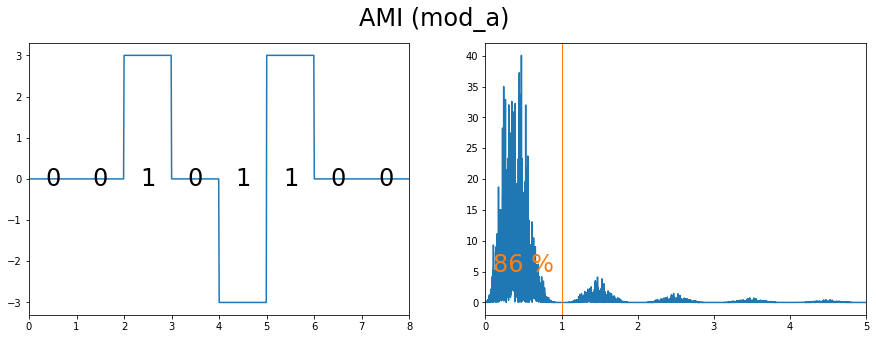

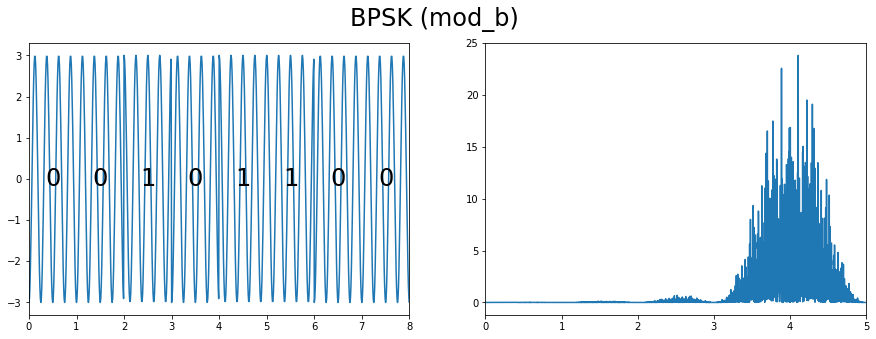

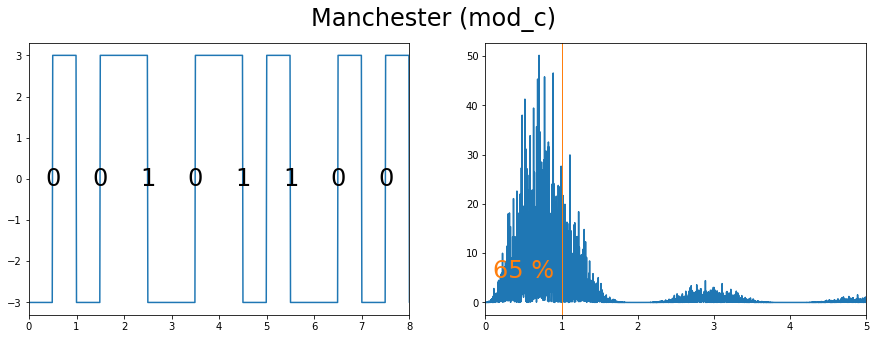

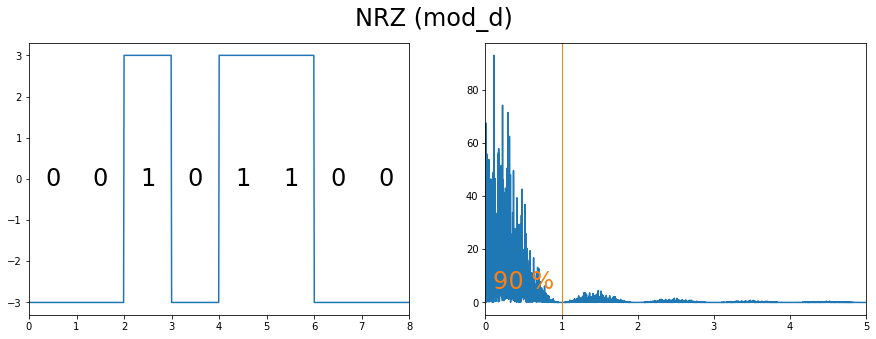

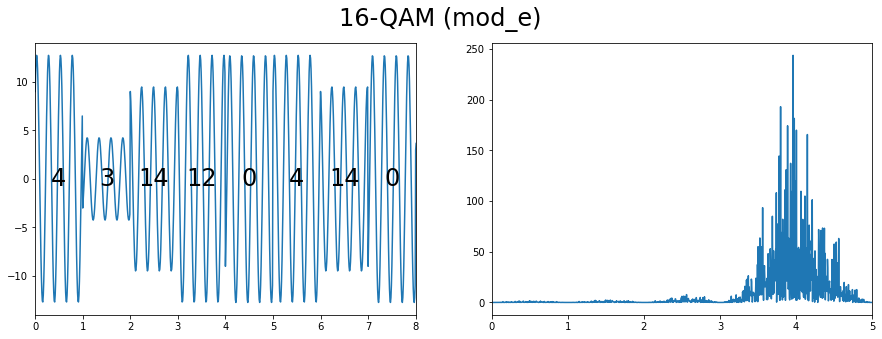

In [4]:
# Modulations à étudier
modulations = {
    "AMI":         cnf.mod_a,
    "BPSK":        cnf.mod_b,
    "Manchester":  cnf.mod_c,
    "NRZ":         cnf.mod_d,
    "16-QAM":      cnf.mod_e,
}

# Amplitude et durée d'un bit
V, T = 3, 1

# Taille de la séquence à afficher
K = 8

# Affichage
for name in modulations:
    
    m = m2 if name != "16-QAM" else m16
    
    # Modulation
    mod = modulations[name]
    t, x = mod(m, V, T)
    
    # Fenêtre
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(f"{name} ({mod.__name__})", fontsize=24)
    tm, fr = ax
    
    # Signal temporel
    tm.plot(t,x)
    tm.set_xlim([0, K*T])
    
    # Texte
    mid = (x.max()+x.min())/2
    for n in range(K):
        tm.text(n*T+T/2, mid, m[n], fontsize=24, ha="center", va="center")
    
    # Densité spectrale de puissance
    f, Pxx = signal.periodogram(x, 100/T)
    fr.plot(f, Pxx)
    fr.set_xlim([0, 5])

    # Fraction d'énergie
    if name in ["AMI", "Manchester", "NRZ"]:
        f0 = 1
        frac = np.sum(Pxx[f<f0]) / np.sum(Pxx)
        fr.axvline(f0, color="tab:orange", linewidth="1")
        fr.text(f0/2, 5, f"{100*frac:.0f} %", color="tab:orange", ha="center", fontsize=24)

Ce tableau compare les différentes modulations en bande de base sur différents critères :

|                              | NRZ | Manchester | AMI |
| ---------------------------- | --- | ---------- | --- |
| Largeur de bande             | 😀  | 😖         | 😀  | 
| Simplicité de mise en œuvre  | 😀  | 😕         | 😕  |
| Robustesse au bruit          | 🙂  | 🙂         | 😖  |
| Synchronisation du récepteur | 😖  | 😀         | 😖  |
| Téléalimentation possible    | 😖  | 😀         | 😀  |
| Inversion de la polarité     | 😖  | 😖         | 😀  |
| Détection d'interruption     | 😀  | 😀         | 😕  |
  
<!--  
 - largeur de sa plage de fréquences : la plus étroite possible
  - téléalimentation : peu de puissance aux faibles fréquences, aucune à la fréquence nulle
  - codage de l'horloge : fréquence suffisante des transitions + synchronisation de l'horloge du récepteur sur le signal reçu
  - résistance au bruit : espacement des niveaux
  - complexité du codage : coût et vitesse de codage
  - dépendance à la polarité : facilité d'installation (Manchester?, AMI, NRZI)
  - équilibrage :
      mesure approximative de l'influence du codage sur des symboles successifs
      Running Digital Sequence : RDS({ak}) = \sum_k ak .
      DRDS({ak}) = max(abs{RDS({aj}) tel que {aj} sous-suite valide de {ak}}).
  - les transmissions en bande de base ont le grand intérêt d'être simples à mettre en place
    et sont donc utilisées dans de nombreux domaines où les communications se font sur de courtes distances.
-->

Selon les résultats de cet exercice, on peut en conclure les modulations adaptées pour les applications suivantes :

* Bus informatique ou de terrain : modulation en bande de base
  (I2C : NRZ,
  SATA : 8b/10b encoding,
  ASI : Manchester,
  KNX : sorte de Manchester,
  HART : FSK binaire superposé au 4-20 mA)
  
* liaison Wi-Fi : modulation sur porteuse
  (QAM, PSK, ou autre suivant la version de la norme)

* périphérique USB et ordinateur : modulation en bande de base
  (NRZI)

* téléphone mobile et antenne relais : modulation sur porteuse
  (GSM = 900 MHz et 1800 MHz, avec variantes)